# Loan Default

## Problem Statement

A key question for many financial institutions is whether an individual or entity will default on a loan. This important question can have wide implications, not just for a single institution, but also for economies as a whole.

This project will look at predicting the probability of default using machine learning methods. 

In [ ]:
# Import time module
import datetime
start_time = datetime.datetime.now()
print(f'Start time: {start_time:%Y-%m-%d %H:%M}')

# Full Module Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import warnings
import shap

# Selective imports
from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.compose import ColumnTransformer
#from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SequentialFeatureSelector   
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from great_tables import GT, md, html

Start time: 2025-01-22 00:54


In [ ]:

# Program Parameters
rand_state = 0              # Random Seed to ensure reproducibility
sample_frac = 1             # Fraction of data frame for stratified sample (ease development time)
train_size = .01            # Set the training size (Higher = More time training)
read_models = False         # Should models be read from disk or fit
save_models = True          # Should the models used be save to disk
include_pairplot = False     # Should pairplots be generated
max_iter = 10_000           # Maximum iterations for Stochastic Gradient Descent Convergence
params = {'dt_clf__min_impurity_decrease': [0.001, 0.01, 0.02, 0.03, 0.05],
          'dt_clf__max_depth': [2, 5, 10],
          'dt_clf__max_features': ['sqrt', 'log2'],
          'dt_clf__min_samples_split': [0.1, 0.2, 0.05],
          'dt_clf__criterion': ['gini', 'entropy']}
rf_params = {'rf_clf__min_impurity_decrease': [0.001, 0.01, 0.02, 0.03, 0.05],
             'rf_clf__max_depth': [2, 5, 10],
             'rf_clf__max_features': ['sqrt', 'log2'],
             'rf_clf__min_samples_split': [0.1, 0.2, 0.05],
             'rf_clf__criterion': ['gini', 'entropy'],
             'rf_clf__n_estimators': [10, 50, 100, 200]}
xgb_params = {'xgb_clf__max_depth': [2, 5, 10],
              'xgb_clf__n_estimators': [10, 50, 100, 200],
              'xgb_clf__learning_rate': [0.1, 0.01, 0.05]}

## Data Cleaning

In [3]:
# Import the raw data set and recode names
name_dict = {'ID':'id',
             'Default':'default',
             'Prct_uso_tc':'pct_cc_usage',
             'Edad':'age',
             'Nro_prestao_retrasados':'num_loans_delayed',
             'Prct_deuda_vs_ingresos':'debt_to_income_ratio',
             'Mto_ingreso_mensual':'mthly_inc_amount',
             'Nro_prod_financieros_deuda':'num_loans_and_cc',
             'Nro_retraso_60dias':'num_late_payments',
             'Nro_creditos_hipotecarios':'num_mtg_loans',
             'Nro_retraso_ultm3anios':'pymt_delays',
             'Nro_dependiente':'num_dependents'}

dtype_dict = {'id':'object',
              'default':'bool',
              'pct_cc_usage':'float64',
              'age':'int64',
              'num_loans_delayed':'int64',
              'debt_to_income_ratio':'float64',
              'mthly_inc_amount':'float64',
              'num_loans_and_cc':'int64',
              'num_late_payments':'int64',
              'num_mtg_loans':'int64',
              'pymt_delays':'int64'}

raw_data = (pd.read_csv('data/credit_scoring.csv')
              .rename(columns=name_dict)
              .astype(dtype_dict))

raw_data.dtypes

id                       object
default                    bool
pct_cc_usage            float64
age                       int64
num_loans_delayed         int64
debt_to_income_ratio    float64
mthly_inc_amount        float64
num_loans_and_cc          int64
num_late_payments         int64
num_mtg_loans             int64
pymt_delays               int64
num_dependents          float64
dtype: object

In [4]:
# Create data dictionary for report inclusion
data_dict = pd.DataFrame({'Original Name':[key for key, value in name_dict.items()],
                          'Analysis Name':[value for key, value in name_dict.items()],
                          'Description':['Identifier',
                                         'Client with more than 90 days without paying their loan',
                                         'Percentage of credit card usage in the last month',
                                         'Age',
                                         'Number of loans with payment delays of more than 3 months in the last 3 years',
                                         'Financial debt-to-income ratio',
                                         'Monthly income amount',
                                         'Number of loans (including vehicle or mortgage loans) and number of credit cards last year',
                                         'Number of times the client has been over 60 days late in the last 3 years',
                                         'Number of mortgage loans',
                                         'Number of payment delays over 30 days in the last 3 years',
                                         'Number of dependents']})

(GT(data_dict)
 .tab_header(title='Loan Default Dataset', subtitle='Data Dictionary')
 .tab_source_note(source_note=md('Source: Kaggle - https://www.kaggle.com/datasets/hugoferquiroz/credit-default-only-numbers'))
 .opt_stylize(style=1, color='blue')
)#.save('assets/data_dictionary.png')

GT(_tbl_data=                 Original Name         Analysis Name  \
0                           ID                    id   
1                      Default               default   
2                  Prct_uso_tc          pct_cc_usage   
3                         Edad                   age   
4       Nro_prestao_retrasados     num_loans_delayed   
5       Prct_deuda_vs_ingresos  debt_to_income_ratio   
6          Mto_ingreso_mensual      mthly_inc_amount   
7   Nro_prod_financieros_deuda      num_loans_and_cc   
8           Nro_retraso_60dias     num_late_payments   
9    Nro_creditos_hipotecarios         num_mtg_loans   
10      Nro_retraso_ultm3anios           pymt_delays   
11             Nro_dependiente        num_dependents   

                                          Description  
0                                          Identifier  
1   Client with more than 90 days without paying t...  
2   Percentage of credit card usage in the last month  
3                                                 Age  
4   Number of loans with payment delays of more th...  
5                      Financial debt-to-income ratio  
6                               Monthly income amount  
7   Number of loans (including vehicle or mortgage...  
8   Number of times the client has been over 60 da...  
9                            Number of mortgage loans  
10  Number of payment delays over 30 days in the l...  
11                               Number of dependents  , _body=<great_tables._gt_data.Body object at 0x74fab6059160>, _boxhead=Boxhead([ColInfo(var='Original Name', type=<ColInfoTypeEnum.default: 1>, column_label='Original Name', column_align='left', column_width=None), ColInfo(var='Analysis Name', type=<ColInfoTypeEnum.default: 1>, column_label='Analysis Name', column_align='left', column_width=None), ColInfo(var='Description', type=<ColInfoTypeEnum.default: 1>, column_label='Description', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x74fab6058d70>, _spanners=Spanners([]), _heading=Heading(title='Loan Default Dataset', subtitle='Data Dictionary', preheader=None), _stubhead=None, _source_notes=[Md(text='Source: Kaggle - https://www.kaggle.com/datasets/hugoferquiroz/credit-default-only-numbers')], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x74fab6059550>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsI

### Stratified Sampling

In [5]:
# This code does a stratified sampling by the target class. This is done only for 
# efficiency purposes in development. For a full production run this should be set
# to 1, so all data is included. However, be prepared as this could take hours to
# run if you are fitting all of the models.
display(raw_data['default'].value_counts())

raw_data = (raw_data.groupby(by=['default'])[list(raw_data.columns)]
                    .apply(lambda x: x.sample(frac = sample_frac, random_state=rand_state))
                    .reset_index(drop=True))

display(raw_data['default'].value_counts())

raw_data.head()


default
False    139974
True      10026
Name: count, dtype: int64

default
False    139974
True      10026
Name: count, dtype: int64

id  default  pct_cc_usage  age  num_loans_delayed  \
0   92967    False      0.004900   73                  0   
1  126140    False      1.000000   42                  0   
2  125434    False      0.702353   28                  0   
3   29063    False      0.766658   54                  0   
4   35748    False      0.038827   50                  0   

   debt_to_income_ratio  mthly_inc_amount  num_loans_and_cc  \
0              0.491189            3120.0                 5   
1            536.000000               NaN                 1   
2              0.526746            6000.0                 6   
3           3019.000000               NaN                 4   
4              0.575043            2331.0                 3   

   num_late_payments  num_mtg_loans  pymt_delays  num_dependents  
0                  0              1            0             0.0  
1                  1              0            0             0.0  
2                  0              1            0             1.0  
3                  0              1            0             0.0  
4                  0              1            0             0.0

### Investigate Missing Values

In [6]:
# Calculate the % null by column
display(raw_data.shape)
(raw_data.isnull().sum()/raw_data.shape[0])*100

(150000, 12)

id                       0.000000
default                  0.000000
pct_cc_usage             0.000000
age                      0.000000
num_loans_delayed        0.000000
debt_to_income_ratio     0.000000
mthly_inc_amount        19.820667
num_loans_and_cc         0.000000
num_late_payments        0.000000
num_mtg_loans            0.000000
pymt_delays              0.000000
num_dependents           2.616000
dtype: float64

### Drop any duplicates

In [7]:
# Drop any duplicates showing data shape before and after
display(raw_data.shape)
data = raw_data.drop_duplicates()
display(data.shape)

(150000, 12)

(150000, 12)

### Check Data Types

In [8]:
# Verify data types
data.dtypes

id                       object
default                    bool
pct_cc_usage            float64
age                       int64
num_loans_delayed         int64
debt_to_income_ratio    float64
mthly_inc_amount        float64
num_loans_and_cc          int64
num_late_payments         int64
num_mtg_loans             int64
pymt_delays               int64
num_dependents          float64
dtype: object

## Data Exploration

### Investigate the Target Variable

Text(0, 0.5, 'Count')

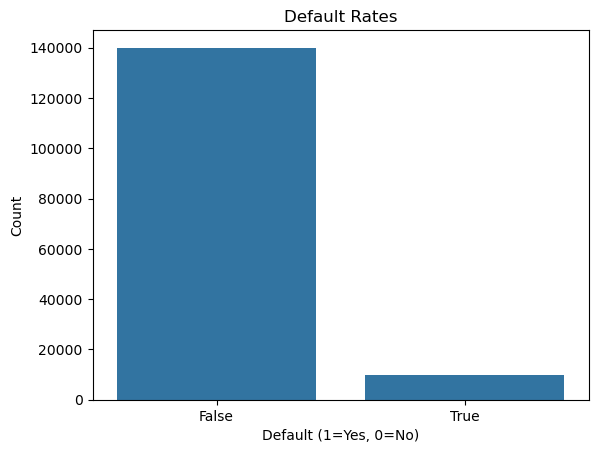

In [9]:
# Plot target feature counts
ax = sns.countplot(data, x='default')
ax.set_title('Default Rates')
ax.set_xlabel('Default (1=Yes, 0=No)')
ax.set_ylabel('Count')

In [10]:
# Calculate the default rate
default_rate = data['default'].mean()
print(f'Default Rate: {default_rate:.1%}')

Default Rate: 6.7%


### Investigate Correlations

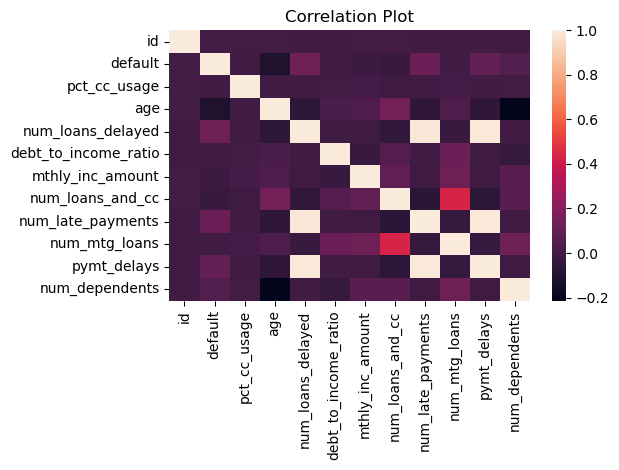

In [11]:
corr = data.corr()
ax = sns.heatmap(corr)
ax.set_title("Correlation Plot")
plt.tight_layout()
plt.savefig('assets/correlation_plot.png')

### Explore and Treat Outliers

Text(0.5, 0.98, 'Distributions by Default')

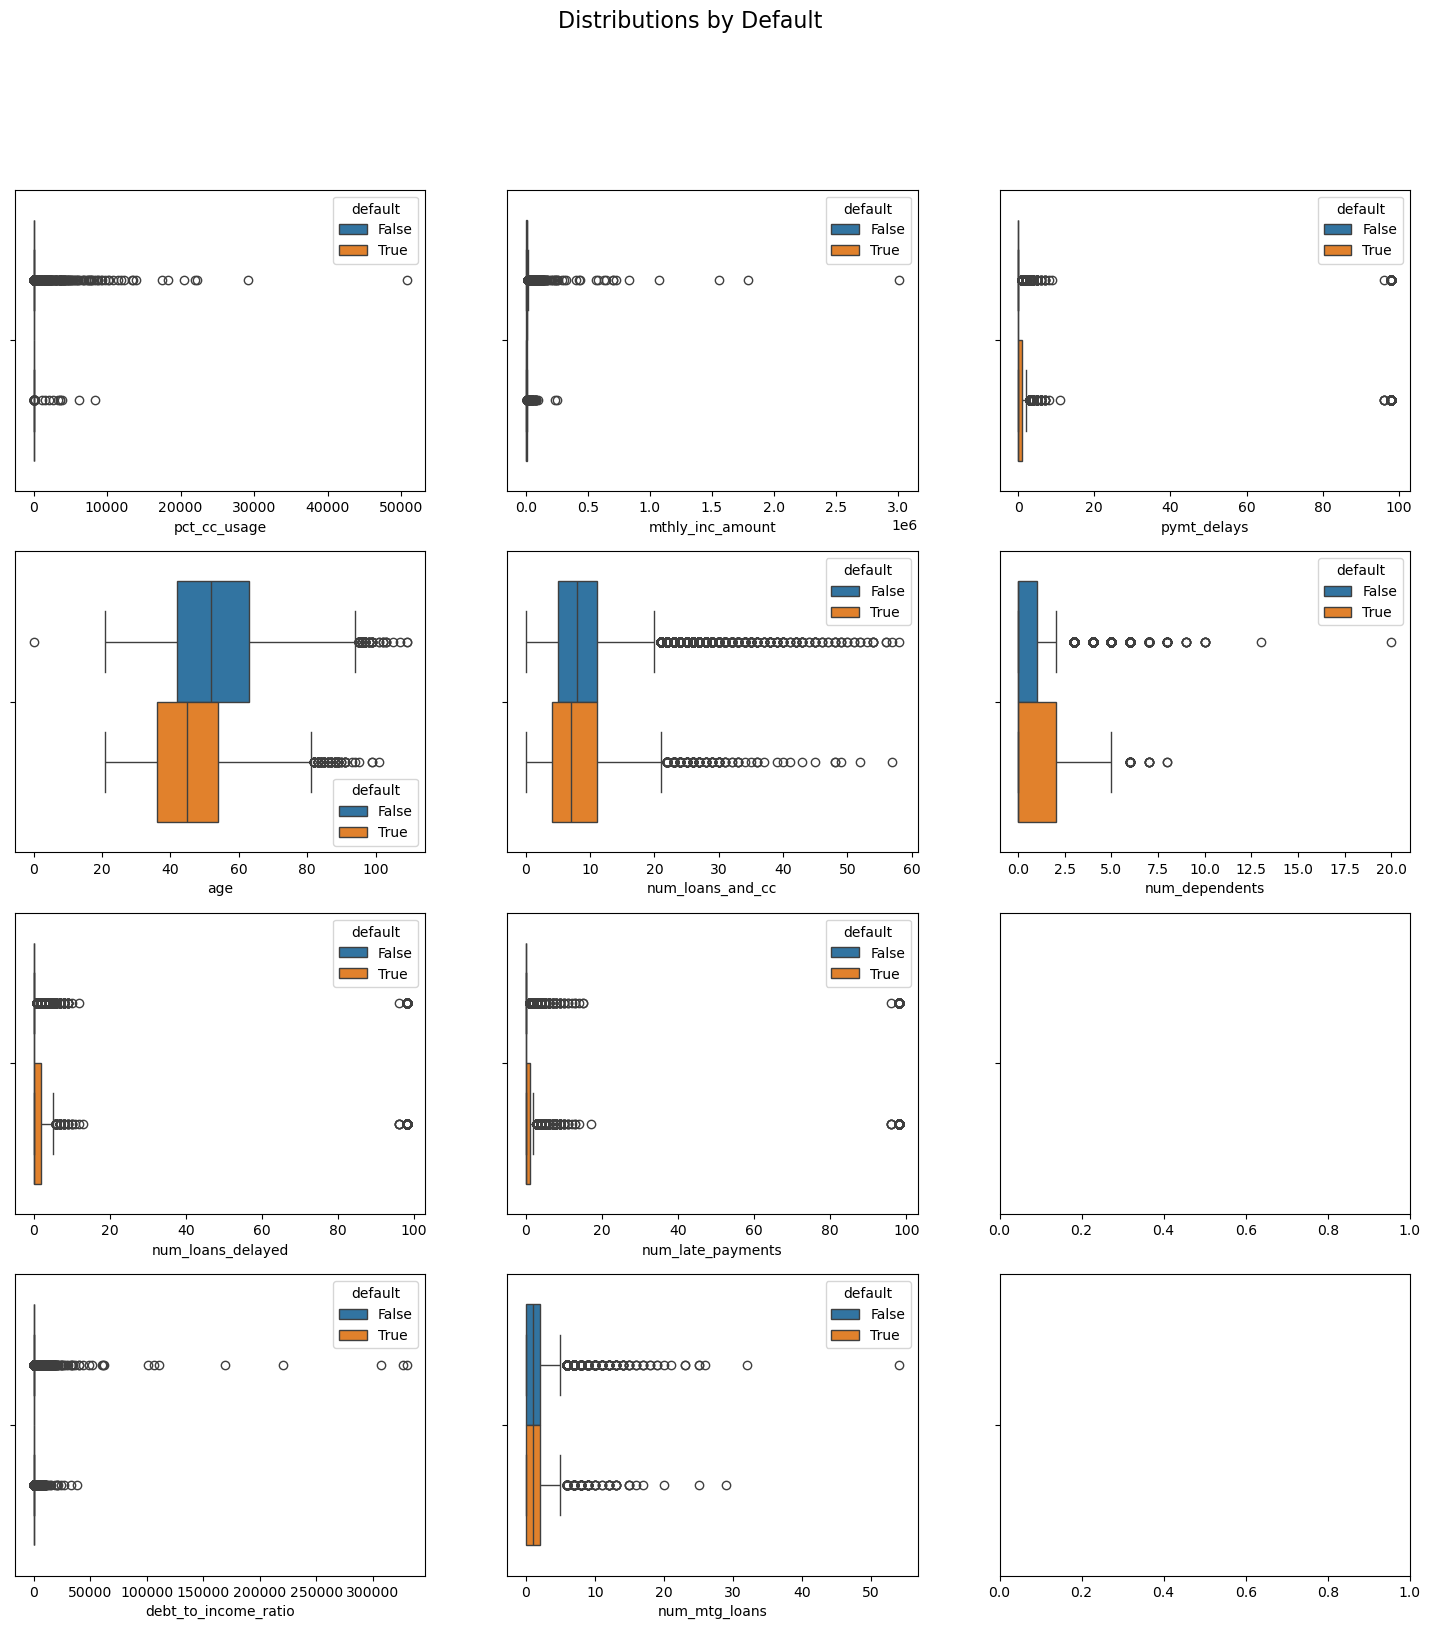

In [12]:
# Look at explanatory feature distributions by the target levels
def dist_charts(data):
    """Create plot with distribution subplots

    Args:
        data (DataFrame): pandas data frame containing the loan default data
    """
    
    fig, axs = plt.subplots(ncols=3, nrows=4, figsize=(18,18), sharey=True)
    sns.boxplot(data, x='pct_cc_usage', hue='default', ax=axs[0,0])
    sns.boxplot(data, x='age', hue='default', ax=axs[1,0])
    sns.boxplot(data, x='num_loans_delayed', hue='default', ax=axs[2,0])
    sns.boxplot(data, x='debt_to_income_ratio', hue='default', ax=axs[3,0])
    
    sns.boxplot(data, x='mthly_inc_amount', hue='default', ax=axs[0,1])
    sns.boxplot(data, x='num_loans_and_cc', hue='default', ax=axs[1,1])
    sns.boxplot(data, x='num_late_payments', hue='default', ax=axs[2,1])
    sns.boxplot(data, x='num_mtg_loans', hue='default', ax=axs[3,1])
    
    sns.boxplot(data, x='pymt_delays', hue='default', ax=axs[0,2])
    sns.boxplot(data, x='num_dependents', hue='default', ax=axs[1,2])
    return((fig, axs))
    
fig, axs = dist_charts(data)
fig.suptitle('Distributions by Default', fontsize=16)

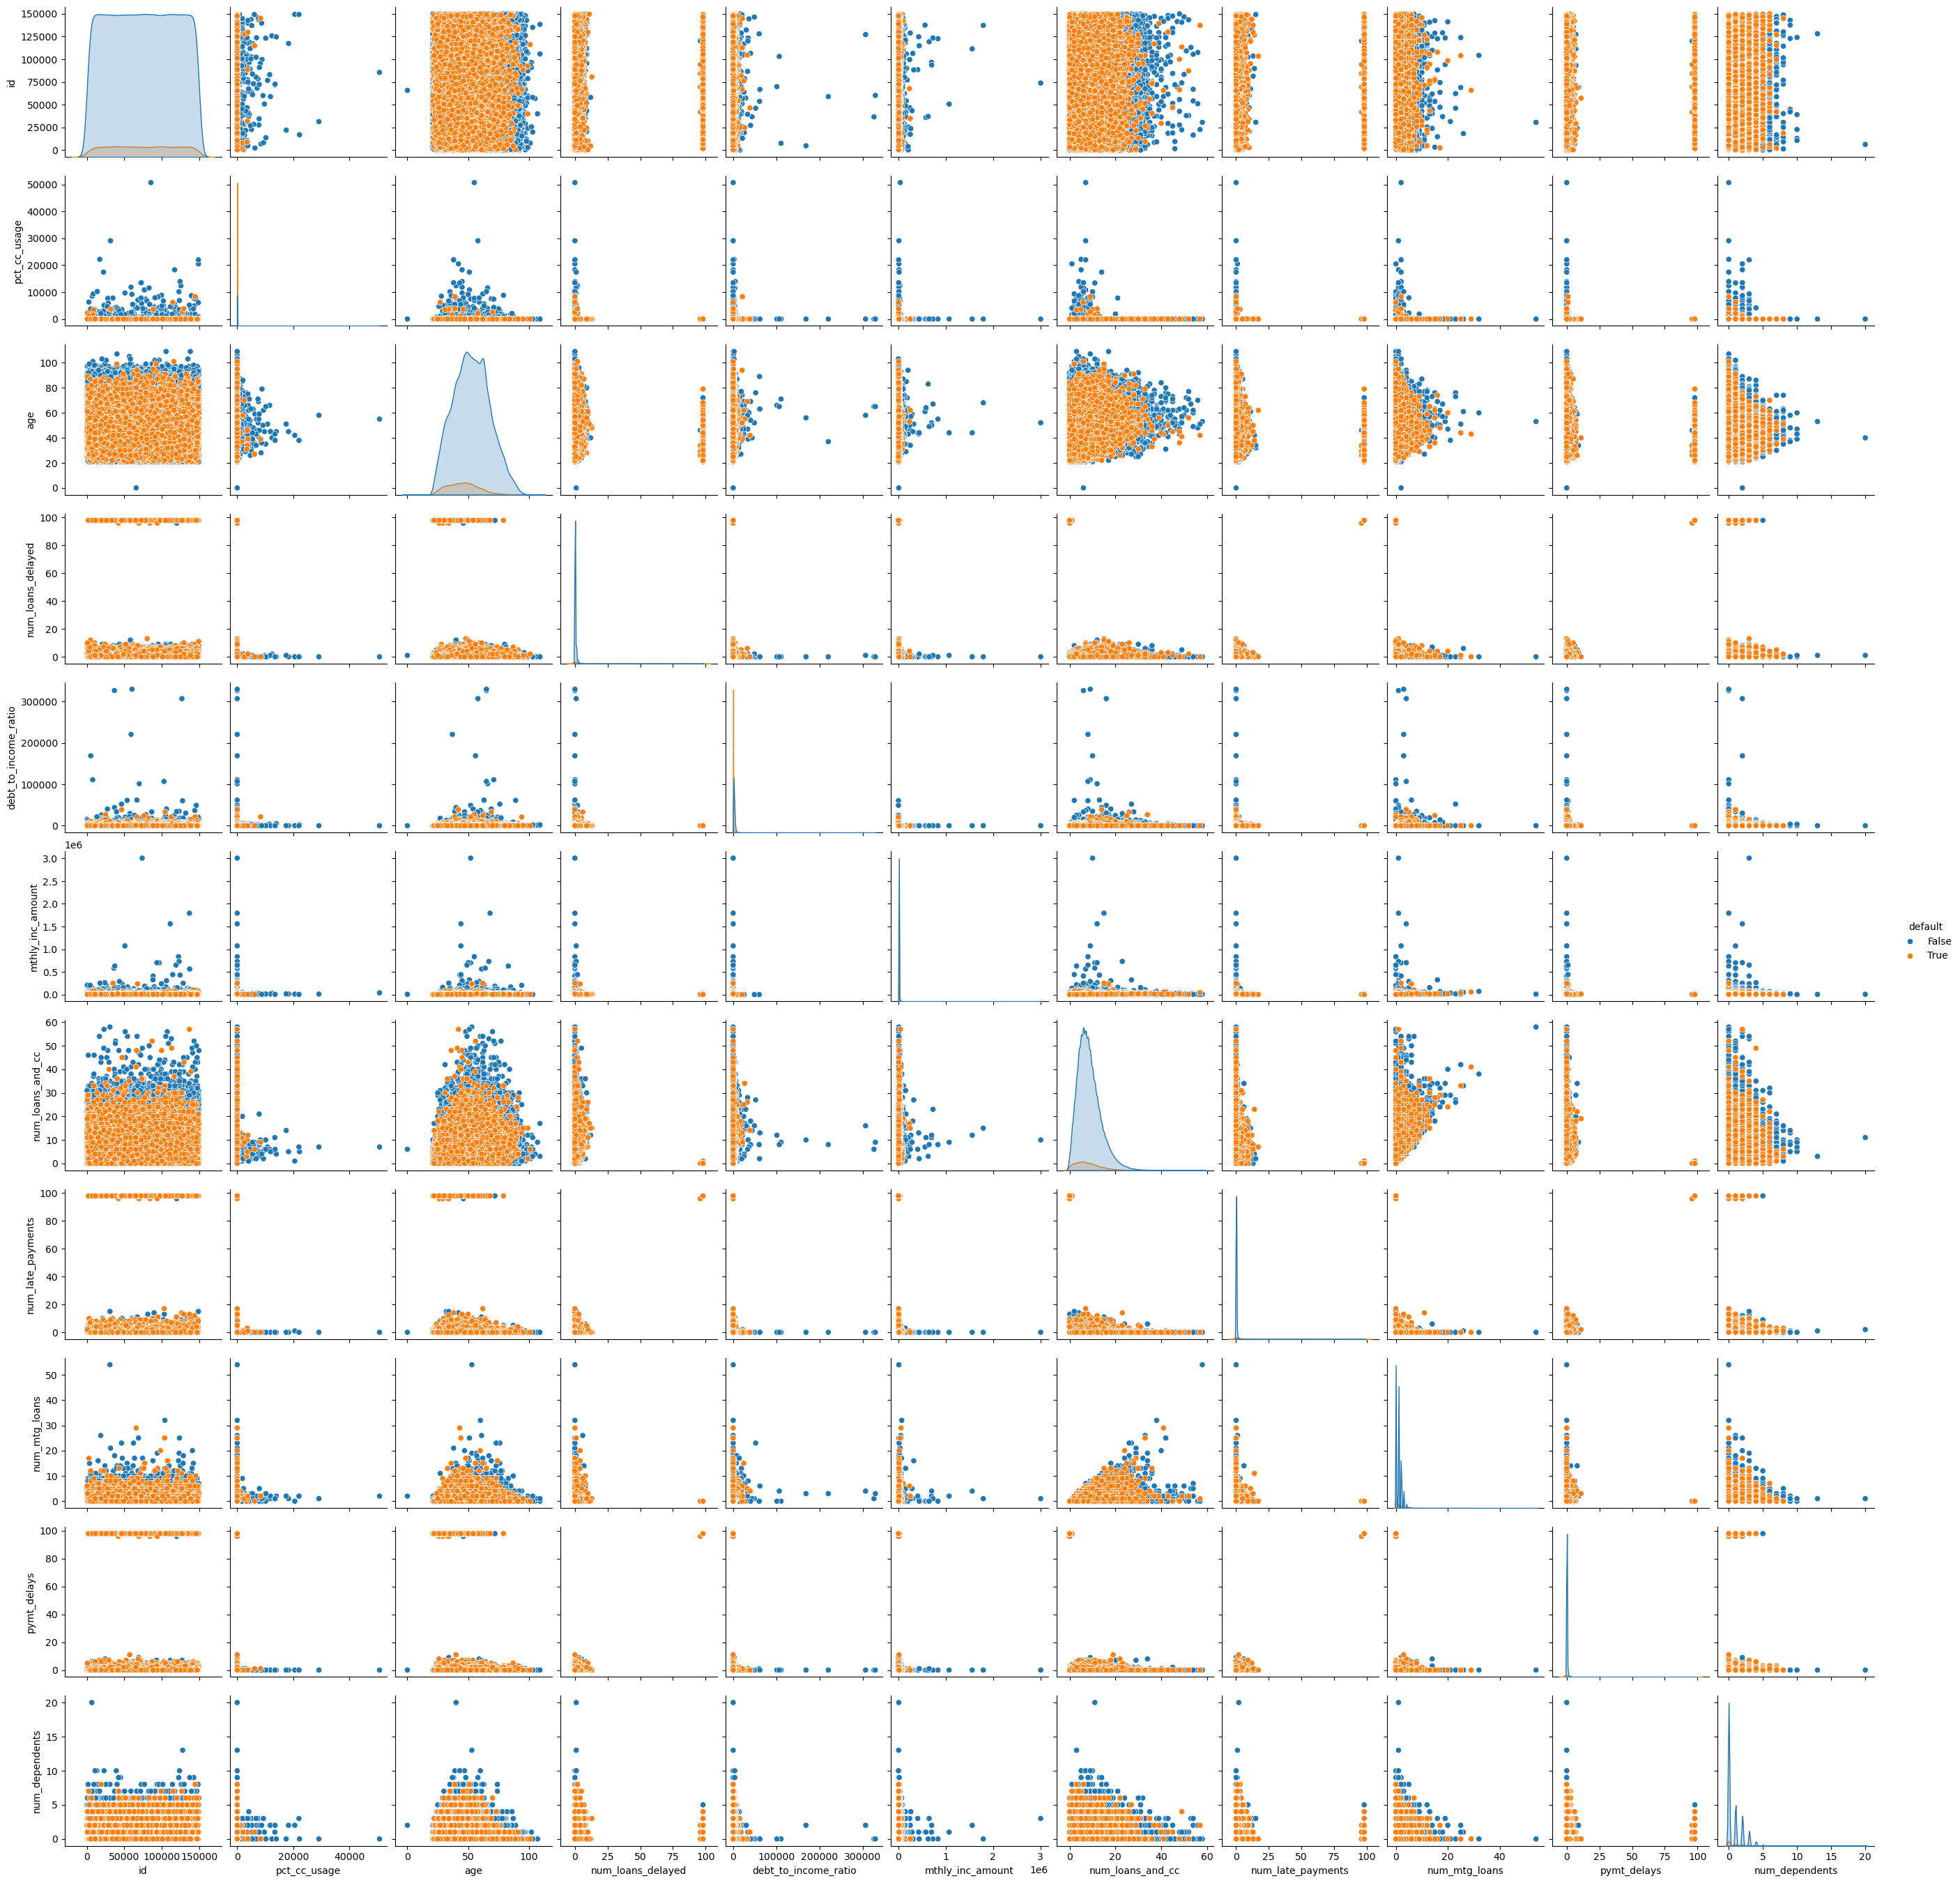

In [13]:
# Examine a pairplot
# This can take about 30 minutes to run
if include_pairplot == True:
    sns.pairplot(data, hue='default')

In [14]:
# Examine Outliers
clf = IsolationForest(random_state=0).fit(data)
data['outlier_score'] = clf.predict(data)
data['outlier_score'].value_counts()

data.columns

Index(['id', 'default', 'pct_cc_usage', 'age', 'num_loans_delayed',
       'debt_to_income_ratio', 'mthly_inc_amount', 'num_loans_and_cc',
       'num_late_payments', 'num_mtg_loans', 'pymt_delays', 'num_dependents',
       'outlier_score'],
      dtype='object')

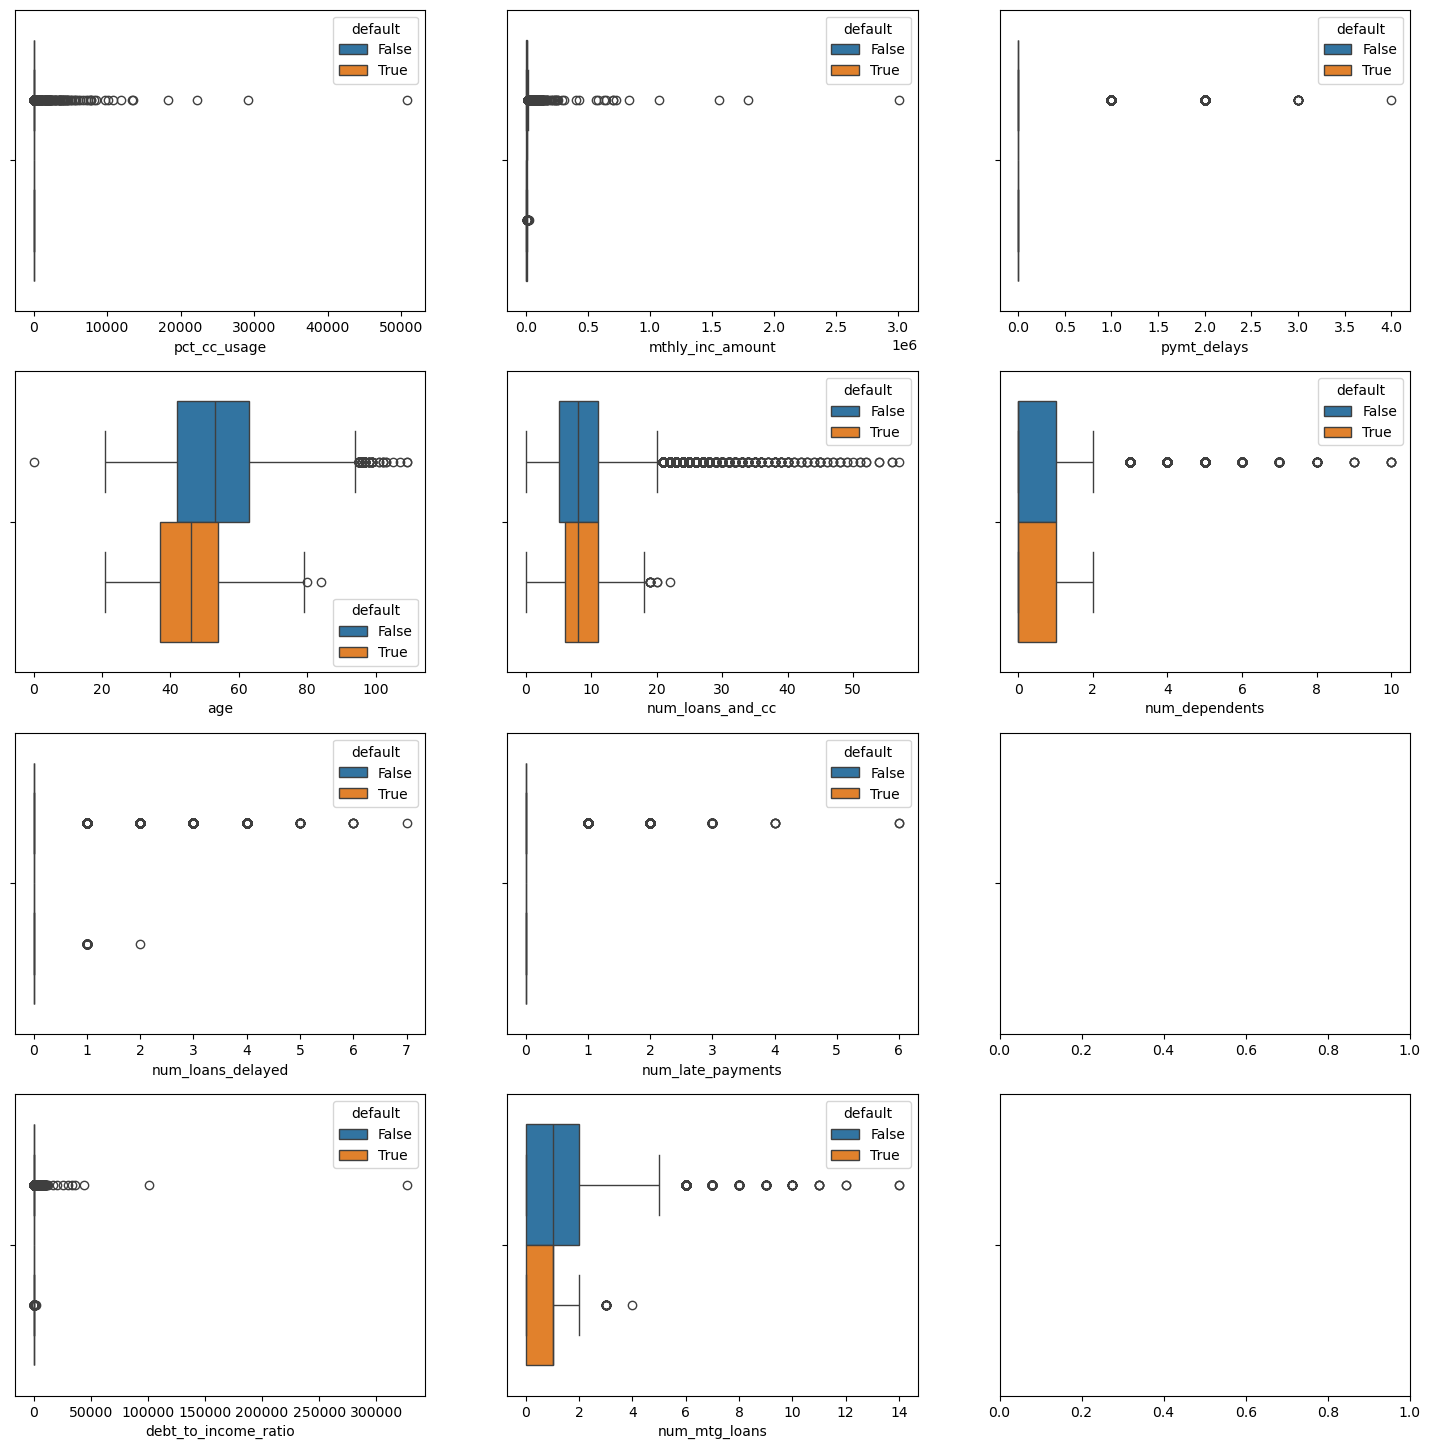

In [15]:
fig, axs = dist_charts(data.query('outlier_score == 1'))

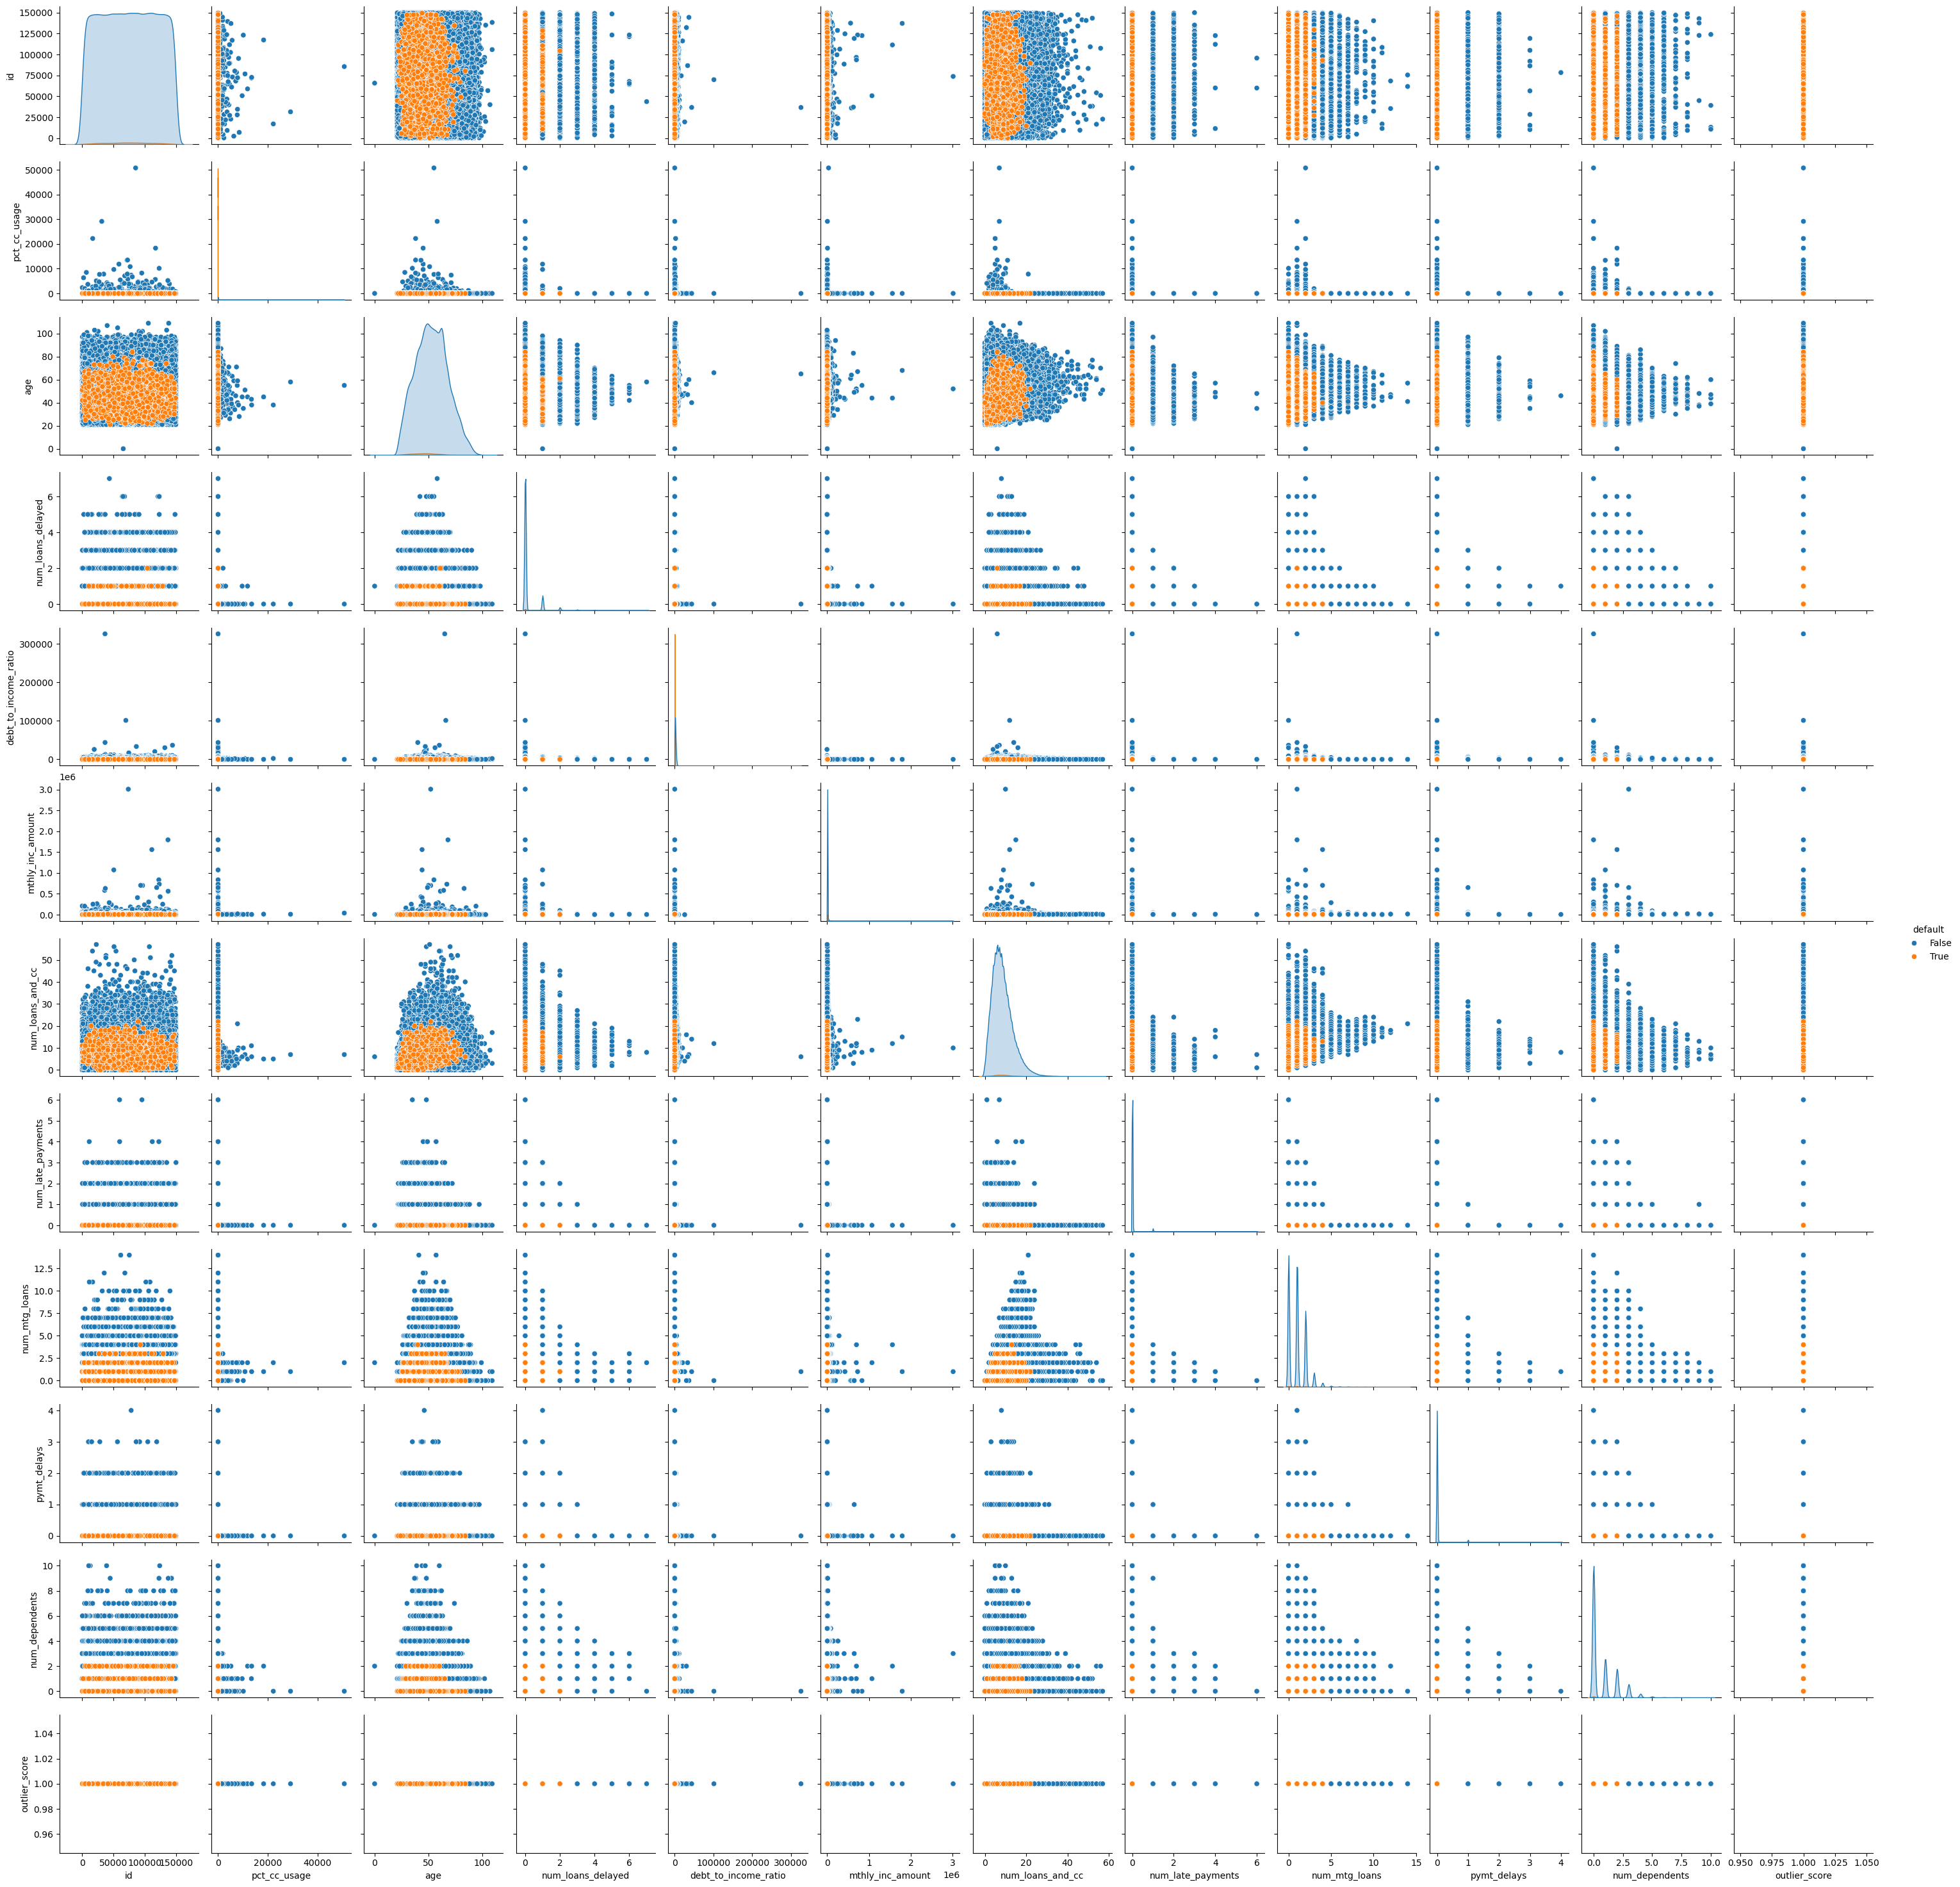

In [16]:
# Remove outliers and pairplot
imp_no_data = data.query('outlier_score == 1')

if include_pairplot == True:
    sns.pairplot(imp_no_data, hue='default')

## Data Preprocessing


### Drop Unnecessary Columns

In [17]:
# Drop the id column
data = data.drop('id', axis=1)

### Create Training & Test Splits

In [18]:
# Create training and testing datasets
data.columns
X, y = data.drop('default', axis=1), data['default']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=.01)

# Extract base feature names to list for later use
base_feature_names = list(X.columns)
target_feature_name = y.name

### Create Resampling Training Sets

## Model Building

In [20]:
# Intialize a dictionary to gather modeling results
model_results = {}

# Initialize Estimators
knn_impute = KNNImputer(weights='uniform')
bsmote = BorderlineSMOTE(random_state=rand_state)
standard_scaler = StandardScaler()
poly_features = PolynomialFeatures(degree=3, include_bias=False)
selector = SequentialFeatureSelector(SGDClassifier(loss='log_loss', n_jobs=-1), 
                                                   n_features_to_select=6,
                                                   n_jobs=-1)

dummy_clf = DummyClassifier(strategy='most_frequent')
lr_sgd = SGDClassifier(loss='log_loss', n_jobs=-1, max_iter=max_iter)
dt_clf = DecisionTreeClassifier(random_state=rand_state)
rf_clf = RandomForestClassifier(random_state=rand_state, n_jobs=-1)
xgb_clf = XGBClassifier()


### Baseline Model (Dummy Classifier)

Training Set Classification Report - Baseline *******
              precision    recall  f1-score   support

       False       0.93      1.00      0.97      1400
        True       0.00      0.00      0.00       100

    accuracy                           0.93      1500
   macro avg       0.47      0.50      0.48      1500
weighted avg       0.87      0.93      0.90      1500

Testing Set Classification Report - Baseline ********
              precision    recall  f1-score   support

       False       0.93      1.00      0.97    138574
        True       0.00      0.00      0.00      9926

    accuracy                           0.93    148500
   macro avg       0.47      0.50      0.48    148500
weighted avg       0.87      0.93      0.90    148500



Text(0.5, 0.98, 'Baseline Confusion Matrix\nNo Sampling')

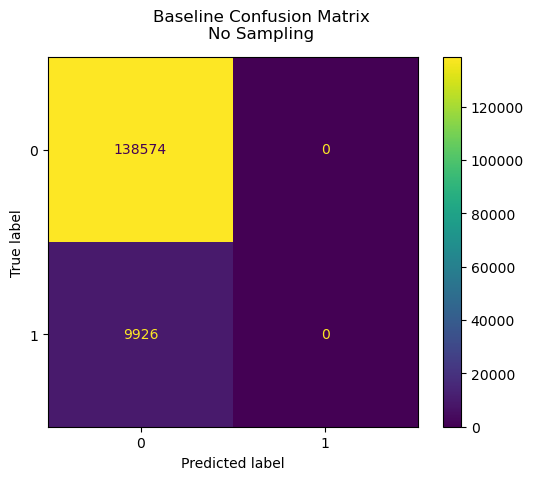

In [21]:
#*******************************************************************************
# Baseline Model and Predictions - No Sampling
#*******************************************************************************

# Filter warnings
warnings.filterwarnings('ignore')

# Create or Load a baseline/naive model
if read_models == False:
    dummy_pipe = Pipeline([('knn_impute', knn_impute),
                           ('dummy_clf', dummy_clf)])
    dummy_pipe.fit(X_train, y_train)
else:
    dummy_pipe = joblib.load('models/dummy_classifier.pkl')

# Conditionally save the classifier
if save_models == True:
    joblib.dump(dummy_pipe, 'models/dummy_classifier.pkl')
    
# Print classification reports
print('Training Set Classification Report - Baseline *******')
print(classification_report(y_train, dummy_pipe.predict(X_train)))
print('Testing Set Classification Report - Baseline ********')
print(classification_report(y_test, dummy_pipe.predict(X_test)))

# Extract classification reports
dummy_train_rpt = classification_report(y_train, dummy_pipe.predict(X_train), output_dict=True)
dummy_test_rpt = classification_report(y_test, dummy_pipe.predict(X_test), output_dict=True)

# Restore warnings
warnings.filterwarnings('always')
    
# Calculate the confusion matrix
dummy_cm = confusion_matrix(y_test, dummy_pipe.predict(X_test))

# Load results
model_results['nosampling_baseline'] = (dummy_train_rpt, dummy_test_rpt, dummy_cm)

# Display baseline results
ConfusionMatrixDisplay(model_results['nosampling_baseline'][2]).plot()
plt.suptitle('Baseline Confusion Matrix\nNo Sampling')

### Logistic Regression

#### Model or Load Logistic Regression Pipeline

/opt/conda/envs/loan_default/lib/python3.13/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=887) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/conda/envs/loan_default/lib/python3.13/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=887) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/conda/envs/loan_default/lib/python3.13/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=887) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/conda/envs/loan_default/lib/python3.13/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=887) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/conda/envs/loan_default/lib/python3.13/site-packages/jo

Training Set Classification Report - Logistic Reg. **
              precision    recall  f1-score   support

       False       0.98      0.98      0.98      1400
        True       0.70      0.76      0.73       100

    accuracy                           0.96      1500
   macro avg       0.84      0.87      0.86      1500
weighted avg       0.96      0.96      0.96      1500

Testing Set Classification Report - Logistic Reg. **
              precision    recall  f1-score   support

       False       0.98      0.98      0.98    138574
        True       0.69      0.79      0.74      9926

    accuracy                           0.96    148500
   macro avg       0.84      0.88      0.86    148500
weighted avg       0.97      0.96      0.96    148500



Text(0.5, 0.98, 'Logistic Regression w/ SGD Confusion Matrix\nNo Sampling')

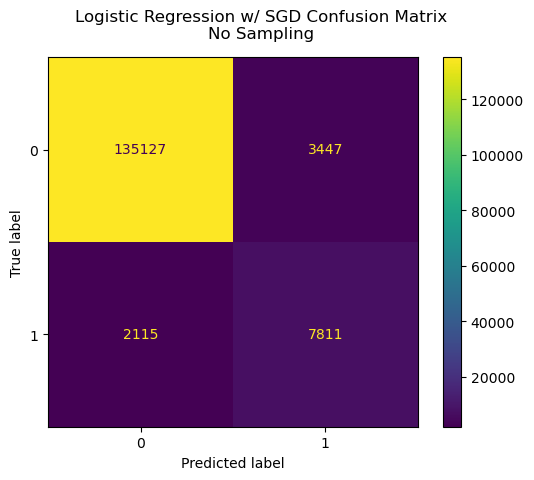

In [22]:
#*******************************************************************************
# Logistic Regression and Predictions - No Sampling
#*******************************************************************************

# Filter warnings
warnings.filterwarnings('always')
    
# Load or fit model
if read_models == False:
    lr_pipe = Pipeline([
        ('knn_imputer', knn_impute),
        ('poly_features', poly_features),
        ('standard_scaler', standard_scaler),
        ('selector', selector),
        ('logistic_regression', lr_sgd)
    ])
    lr_pipe.fit(X_train, y_train)
else:
    lr_pipe = joblib.load('models/lr_nosampling_pipe.pkl')

# Conditionally save the model
if save_models == True:
    joblib.dump(lr_pipe, 'models/lr_nosampling_pipe.pkl')

# Print the classification reports
print('Training Set Classification Report - Logistic Reg. **')
print(classification_report(y_train, lr_pipe.predict(X_train)))
print('Testing Set Classification Report - Logistic Reg. **')
print(classification_report(y_test, lr_pipe.predict(X_test)))
    
# Extract classification reports
lr_train_rpt = classification_report(y_train, lr_pipe.predict(X_train), output_dict=True)
lr_test_rpt = classification_report(y_test, lr_pipe.predict(X_test), output_dict=True)

# Restore warnings
warnings.filterwarnings('always')

# Calculate the confusion matrix
lr_cm = confusion_matrix(y_test, lr_pipe.predict(X_test))
    
# Fit logistic regression model w/o sampling
model_results['nosampling_lr'] = (lr_train_rpt, lr_test_rpt, lr_cm)

# Display logistic regression results
ConfusionMatrixDisplay(model_results['nosampling_lr'][2]).plot()
plt.suptitle('Logistic Regression w/ SGD Confusion Matrix\nNo Sampling')


/opt/conda/envs/loan_default/lib/python3.13/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/conda/envs/loan_default/lib/python3.13/site-packages/sklearn/utils/_tags.py:354: DeprecationWarning: The BorderlineSMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Training Set Classification Report - Logistic Reg. **
              precision    recall  f1-score   support

       False       0.99      0.97      0.98      1400
        True       0.66      0.82      0.73       100

    accuracy                           0.96      1500
   macro avg       0.82      0.90      0.86      1500
weighted avg       0.97      0.96      0.96      1500

Testing Set Classification Report - Logistic Reg. **
              precision    recall  f1-score   support

       False       0.99      0.97      0.98    138574
        True       0.66      0.83      0.74      9926

    accuracy                           0.96    148500
   macro avg       0.83      0.90      0.86    148500
weighted avg       0.97      0.96      0.96    148500



Text(0.5, 0.98, 'Logistic Regression w/ SGD Confusion Matrix\nBorderline SMOTE')

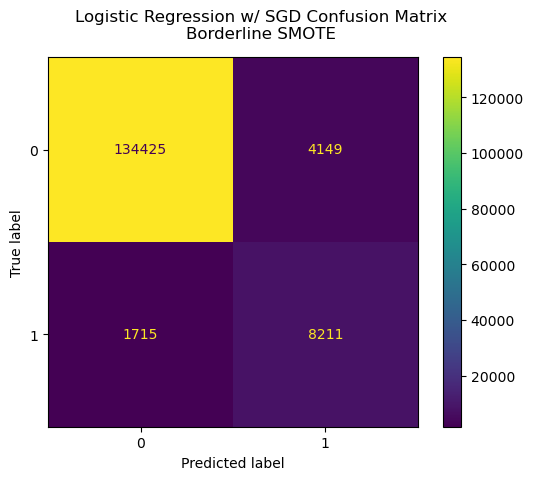

In [23]:
#*******************************************************************************
# Logistic Regression and Predictions - With Sampling (BSMOTE)
#*******************************************************************************

# Filter warnings
warnings.filterwarnings('always')
    
# Load or fit model
if read_models == False:
    lr_pipe = Pipeline([
        ('knn_imputer', knn_impute),
        ('bsmote', bsmote),
        ('poly_features', poly_features),
        ('standard_scaler', standard_scaler),
        ('selector', selector),
        ('logistic_regression', lr_sgd)
    ])
    lr_pipe.fit(X_train, y_train)
else:
    lr_pipe = joblib.load('models/lr_borderlineSMOTE_pipe.pkl')

# Conditionally save the model
if save_models == True:
    joblib.dump(lr_pipe, 'models/lr_borderlineSMOTE_pipe.pkl')

# Print the classification reports
print('Training Set Classification Report - Logistic Reg. **')
print(classification_report(y_train, lr_pipe.predict(X_train)))
print('Testing Set Classification Report - Logistic Reg. **')
print(classification_report(y_test, lr_pipe.predict(X_test)))
    
# Extract classification reports
slr_train_rpt = classification_report(y_train, lr_pipe.predict(X_train), output_dict=True)
slr_test_rpt = classification_report(y_test, lr_pipe.predict(X_test), output_dict=True)

# Restore warnings
warnings.filterwarnings('always')

# Calculate the confusion matrix
slr_cm = confusion_matrix(y_test, lr_pipe.predict(X_test))
    
model_results['borderlineSMOTE_lr'] = (slr_train_rpt, slr_test_rpt, slr_cm)

# Display logistic regression results
ConfusionMatrixDisplay(model_results['borderlineSMOTE_lr'][2]).plot()
plt.suptitle('Logistic Regression w/ SGD Confusion Matrix\nBorderline SMOTE')


### Decision Tree

Training Set Classification Report - Decision Tree **
              precision    recall  f1-score   support

       False       0.98      0.98      0.98      1400
        True       0.70      0.69      0.70       100

    accuracy                           0.96      1500
   macro avg       0.84      0.83      0.84      1500
weighted avg       0.96      0.96      0.96      1500

Testing Set Classification Report - Decision Tree ***
              precision    recall  f1-score   support

       False       0.97      0.98      0.98    138574
        True       0.66      0.63      0.64      9926

    accuracy                           0.95    148500
   macro avg       0.82      0.80      0.81    148500
weighted avg       0.95      0.95      0.95    148500



Text(0.5, 0.98, 'Decision Tree Confusion Matrix\nNo Sampling')

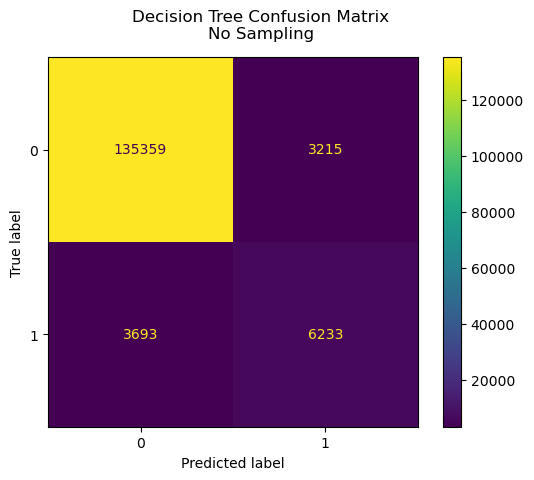

In [24]:
#*******************************************************************************
# Decision Tree and Predictions - No Sampling
#*******************************************************************************

# Implement a decision tree using gridCV
if read_models == False:
    dt_pipe = Pipeline([
        ('knn_imputer', knn_impute),
        ('standard_scaler', standard_scaler),
        ('dt_clf', dt_clf)
    ])
    
    dt_grid = GridSearchCV(dt_pipe,
                           param_grid=params,
                           scoring='recall',
                           n_jobs=-1).fit(X_train, y_train)
else:
    dt_grid = joblib.load('models/dt_nosampling_classifier.pkl')
    
if save_models == True:
    joblib.dump(dt_grid, 'models/dt_nosampling_classifier.pkl')

# Print the classification reports
print('Training Set Classification Report - Decision Tree **')
print(classification_report(y_train, dt_grid.predict(X_train)))
print('Testing Set Classification Report - Decision Tree ***')
print(classification_report(y_test, dt_grid.predict(X_test)))

# Extract classification reports
dt_train_rpt = classification_report(y_train, dt_grid.predict(X_train), output_dict=True)
dt_test_rpt = classification_report(y_test, dt_grid.predict(X_test), output_dict=True)
    
# Calculate the confusion matrix
dt_cm = confusion_matrix(y_test, dt_grid.predict(X_test))

# Fit decision tree model
model_results['nosampling_dt'] = (dt_train_rpt, dt_test_rpt, dt_cm)

# Display decision tree results
ConfusionMatrixDisplay(model_results['nosampling_dt'][2]).plot()
plt.suptitle('Decision Tree Confusion Matrix\nNo Sampling')


/opt/conda/envs/loan_default/lib/python3.13/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/conda/envs/loan_default/lib/python3.13/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/conda/envs/loan_default/lib/python3.13/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/conda/envs/loan_default/lib/pyth

Training Set Classification Report - Decision Tree **
              precision    recall  f1-score   support

       False       0.98      0.65      0.78      1400
        True       0.14      0.82      0.25       100

    accuracy                           0.66      1500
   macro avg       0.56      0.74      0.52      1500
weighted avg       0.92      0.66      0.75      1500

Testing Set Classification Report - Decision Tree ***
              precision    recall  f1-score   support

       False       0.98      0.65      0.78    138574
        True       0.15      0.82      0.25      9926

    accuracy                           0.66    148500
   macro avg       0.56      0.74      0.52    148500
weighted avg       0.93      0.66      0.75    148500



Text(0.5, 0.98, 'Decision Tree Confusion Matrix\nBorderline SMOTE')

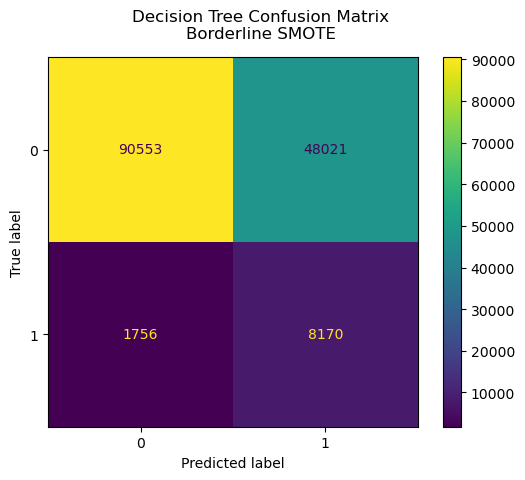

In [25]:
#*******************************************************************************
# Decision Tree and Predictions - With Sampling
#*******************************************************************************

# Implement a decision tree using gridCV
if read_models == False:
    dt_pipe = Pipeline([
        ('knn_imputer', knn_impute),
        ('bsmote', bsmote),
        ('standard_scaler', standard_scaler),
        ('dt_clf', dt_clf)
    ])
    
    dt_grid = GridSearchCV(dt_pipe,
                           param_grid=params,
                           scoring='recall',
                           n_jobs=-1).fit(X_train, y_train)
else:
    dt_grid = joblib.load('models/dt_borderlineSMOTE_classifier.pkl')
    
if save_models == True:
    joblib.dump(dt_grid, 'models/dt_borderlineSMOTE_classifier.pkl')

# Print the classification reports
print('Training Set Classification Report - Decision Tree **')
print(classification_report(y_train, dt_grid.predict(X_train)))
print('Testing Set Classification Report - Decision Tree ***')
print(classification_report(y_test, dt_grid.predict(X_test)))

# Extract classification reports
sdt_train_rpt = classification_report(y_train, dt_grid.predict(X_train), output_dict=True)
sdt_test_rpt = classification_report(y_test, dt_grid.predict(X_test), output_dict=True)
    
# Calculate the confusion matrix
sdt_cm = confusion_matrix(y_test, dt_grid.predict(X_test))

model_results['borderlineSMOTE_dt'] = (sdt_train_rpt, sdt_test_rpt, sdt_cm)

# Display decision tree results
ConfusionMatrixDisplay(model_results['borderlineSMOTE_dt'][2]).plot()
plt.suptitle('Decision Tree Confusion Matrix\nBorderline SMOTE')


### Random Forest

Training Set Classification Report - Random Forest **
              precision    recall  f1-score   support

       False       0.98      0.98      0.98      1400
        True       0.75      0.75      0.75       100

    accuracy                           0.97      1500
   macro avg       0.87      0.87      0.87      1500
weighted avg       0.97      0.97      0.97      1500

Testing Set Classification Report - Random Forest ***
              precision    recall  f1-score   support

       False       0.98      0.98      0.98    138574
        True       0.69      0.68      0.69      9926

    accuracy                           0.96    148500
   macro avg       0.83      0.83      0.83    148500
weighted avg       0.96      0.96      0.96    148500



Text(0.5, 0.98, 'Random Forest Confusion Matrix\nNo Sampling')

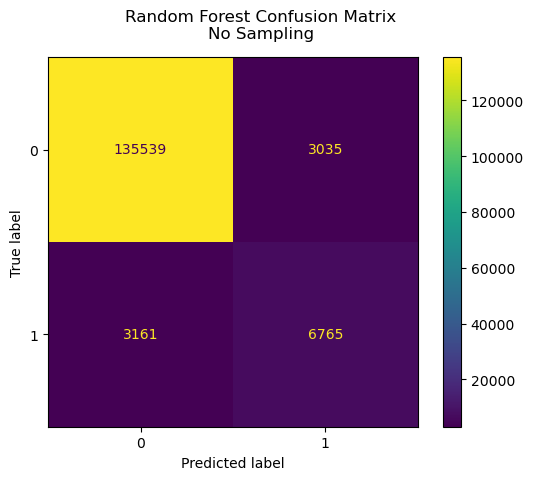

In [26]:
#*******************************************************************************
# Random Forest and Predictions - No Sampling
#*******************************************************************************

# Implement a decision tree using gridCV
if read_models == False:
    rf_pipe = Pipeline([('knn_impute', knn_impute),
                        ('standard_scaler', standard_scaler),
                        ('rf_clf', rf_clf)])
    rf_grid = GridSearchCV(rf_pipe,
                           param_grid=rf_params,
                           scoring='recall',
                           n_jobs=-1).fit(X_train, y_train)
else:
    rf_grid = joblib.load('models/rf_nosampling_classifier.pkl')

if save_models == True:
    joblib.dump(rf_grid, 'models/rf_nosampling_classifier.pkl')

# Print the classification reports
print('Training Set Classification Report - Random Forest **')
print(classification_report(y_train, rf_grid.predict(X_train)))
print('Testing Set Classification Report - Random Forest ***')
print(classification_report(y_test, rf_grid.predict(X_test)))
    
# Calculate the confusion matrix
rf_cm = confusion_matrix(y_test, rf_grid.predict(X_test))

# Extract classification reports
rf_train_rpt = classification_report(y_train, rf_grid.predict(X_train), output_dict=True)
rf_test_rpt = classification_report(y_test, rf_grid.predict(X_test), output_dict=True) 

model_results['nosampling_rf'] = (rf_train_rpt, rf_test_rpt, rf_cm)

# Plot the confusion matrix
ConfusionMatrixDisplay(model_results['nosampling_rf'][2]).plot()
plt.suptitle('Random Forest Confusion Matrix\nNo Sampling')


/opt/conda/envs/loan_default/lib/python3.13/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/conda/envs/loan_default/lib/python3.13/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/conda/envs/loan_default/lib/python3.13/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/conda/envs/loan_default/lib/pyth

Training Set Classification Report - Random Forest **
              precision    recall  f1-score   support

       False       0.99      0.96      0.98      1400
        True       0.62      0.85      0.72       100

    accuracy                           0.96      1500
   macro avg       0.80      0.91      0.85      1500
weighted avg       0.96      0.96      0.96      1500

Testing Set Classification Report - Random Forest ***
              precision    recall  f1-score   support

       False       0.99      0.96      0.98    138574
        True       0.62      0.87      0.73      9926

    accuracy                           0.96    148500
   macro avg       0.81      0.92      0.85    148500
weighted avg       0.97      0.96      0.96    148500



Text(0.5, 0.98, 'Random Forest Confusion Matrix\nBorderline SMOTE')

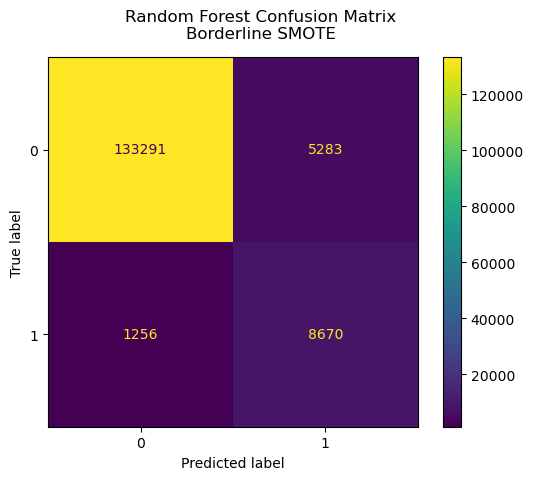

In [27]:
#*******************************************************************************
# Random Forest and Predictions - With Sampling
#*******************************************************************************

# Implement a decision tree using gridCV
if read_models == False:
    rf_pipe = Pipeline([('knn_impute', knn_impute),
                        ('bsmote', bsmote),
                        ('standard_scaler', standard_scaler),
                        ('rf_clf', rf_clf)])
    rf_grid = GridSearchCV(rf_pipe,
                           param_grid=rf_params,
                           scoring='recall',
                           n_jobs=-1).fit(X_train, y_train)
else:
    rf_grid = joblib.load('models/rf_borderlineSMOTE_classifier.pkl')

if save_models == True:
    joblib.dump(rf_grid, 'models/rf_borderlineSMOTE_classifier.pkl')

# Print the classification reports
print('Training Set Classification Report - Random Forest **')
print(classification_report(y_train, rf_grid.predict(X_train)))
print('Testing Set Classification Report - Random Forest ***')
print(classification_report(y_test, rf_grid.predict(X_test)))

# Extract classification reports
srf_train_rpt = classification_report(y_train, rf_grid.predict(X_train), output_dict=True)
srf_test_rpt = classification_report(y_test, rf_grid.predict(X_test), output_dict=True) 
    
# Calculate the confusion matrix
srf_cm = confusion_matrix(y_test, rf_grid.predict(X_test))

model_results['borderlineSMOTE_rf'] = (srf_train_rpt, srf_test_rpt, srf_cm)

# Plot the confusion matrix
ConfusionMatrixDisplay(model_results['borderlineSMOTE_rf'][2]).plot()
plt.suptitle('Random Forest Confusion Matrix\nBorderline SMOTE')

### XGBoost

/opt/conda/envs/loan_default/lib/python3.13/site-packages/sklearn/utils/_tags.py:354: DeprecationWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Training Set Classification Report - XGBoost **
              precision    recall  f1-score   support

       False       0.98      1.00      0.99      1400
        True       0.96      0.78      0.86       100

    accuracy                           0.98      1500
   macro avg       0.97      0.89      0.93      1500
weighted avg       0.98      0.98      0.98      1500

Testing Set Classification Report - XGBoost ***


/opt/conda/envs/loan_default/lib/python3.13/site-packages/sklearn/utils/_tags.py:354: DeprecationWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/opt/conda/envs/loan_default/lib/python3.13/site-packages/sklearn/utils/_tags.py:354: DeprecationWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From 

              precision    recall  f1-score   support

       False       0.98      0.98      0.98    138574
        True       0.74      0.66      0.70      9926

    accuracy                           0.96    148500
   macro avg       0.86      0.82      0.84    148500
weighted avg       0.96      0.96      0.96    148500



/opt/conda/envs/loan_default/lib/python3.13/site-packages/sklearn/utils/_tags.py:354: DeprecationWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/opt/conda/envs/loan_default/lib/python3.13/site-packages/sklearn/utils/_tags.py:354: DeprecationWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From 

Text(0.5, 0.98, 'Random Forest Confusion Matrix\nNo Sampling')

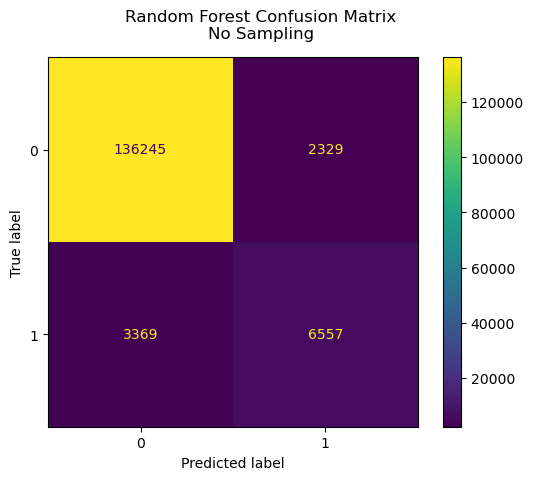

In [28]:
#*******************************************************************************
# XGBoost and Predictions - No Sampling
#*******************************************************************************

# Implement a XGBoost
if read_models == False:
    xgb_pipe = Pipeline([('knn_impute', knn_impute),
                        ('standard_scaler', standard_scaler),
                        ('xgb_clf', xgb_clf)])
    xgb_grid = GridSearchCV(estimator=xgb_pipe,
                            param_grid=xgb_params,
                            n_jobs=-1).fit(X_train, y_train)
else:
    xgb_grid = joblib.load('models/xgb_nosampling_classifier.pkl')

if save_models == True:
    joblib.dump(xgb_grid, 'models/xgb_nosampling_classifier.pkl')

# Print the classification reports
print('Training Set Classification Report - XGBoost **')
print(classification_report(y_train, xgb_grid.predict(X_train)))
print('Testing Set Classification Report - XGBoost ***')
print(classification_report(y_test, xgb_grid.predict(X_test)))
    
# Calculate the confusion matrix
xgb_cm = confusion_matrix(y_test, xgb_grid.predict(X_test))

# Extract classification reports
xgb_train_rpt = classification_report(y_train, xgb_grid.predict(X_train), output_dict=True)
xgb_test_rpt = classification_report(y_test, xgb_grid.predict(X_test), output_dict=True) 

model_results['nosampling_xgb'] = (xgb_train_rpt, xgb_test_rpt, xgb_cm)

# Plot the confusion matrix
ConfusionMatrixDisplay(model_results['nosampling_xgb'][2]).plot()
plt.suptitle('Random Forest Confusion Matrix\nNo Sampling')


/opt/conda/envs/loan_default/lib/python3.13/site-packages/sklearn/utils/_tags.py:354: DeprecationWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/opt/conda/envs/loan_default/lib/python3.13/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/conda/envs/loan_default/lib/python3.13/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is depreca

Training Set Classification Report - XGBoost **
              precision    recall  f1-score   support

       False       0.99      0.99      0.99      1400
        True       0.89      0.85      0.87       100

    accuracy                           0.98      1500
   macro avg       0.94      0.92      0.93      1500
weighted avg       0.98      0.98      0.98      1500

Testing Set Classification Report - XGBoost ***


/opt/conda/envs/loan_default/lib/python3.13/site-packages/sklearn/utils/_tags.py:354: DeprecationWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


              precision    recall  f1-score   support

       False       0.98      0.97      0.98    138574
        True       0.69      0.78      0.73      9926

    accuracy                           0.96    148500
   macro avg       0.84      0.88      0.86    148500
weighted avg       0.96      0.96      0.96    148500



/opt/conda/envs/loan_default/lib/python3.13/site-packages/sklearn/utils/_tags.py:354: DeprecationWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/opt/conda/envs/loan_default/lib/python3.13/site-packages/sklearn/utils/_tags.py:354: DeprecationWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From 

Text(0.5, 0.98, 'XGBoost Confusion Matrix\nBorderline SMOTE')

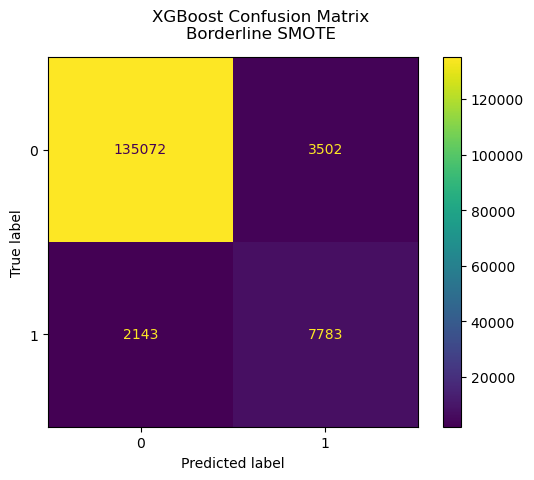

In [29]:
#*******************************************************************************
# XGBoost and Predictions - With Sampling
#*******************************************************************************

# Implement a XGBoost
if read_models == False:
    xgb_pipe = Pipeline([('knn_impute', knn_impute),
                         ('bsmote', bsmote),
                         ('standard_scaler', standard_scaler),
                         ('xgb_clf', xgb_clf)])
    xgb_grid = GridSearchCV(estimator=xgb_pipe,
                            param_grid=xgb_params,
                            n_jobs=-1).fit(X_train, y_train)
else:
    xgb_grid = joblib.load('models/xgb_borderlineSMOTE_classifier.pkl')

if save_models == True:
    joblib.dump(xgb_grid, 'models/xgb_borderlineSMOTE_classifier.pkl')

# Print the classification reports
print('Training Set Classification Report - XGBoost **')
print(classification_report(y_train, xgb_grid.predict(X_train)))
print('Testing Set Classification Report - XGBoost ***')
print(classification_report(y_test, xgb_grid.predict(X_test)))
    
# Calculate the confusion matrix
sxgb_cm = confusion_matrix(y_test, xgb_grid.predict(X_test))

# Extract classification reports
sxgb_train_rpt = classification_report(y_train, xgb_grid.predict(X_train), output_dict=True)
sxgb_test_rpt = classification_report(y_test, xgb_grid.predict(X_test), output_dict=True) 

model_results['borderlineSMOTE_xgb'] = (sxgb_train_rpt, sxgb_test_rpt, sxgb_cm)

# Plot the confusion matrix
ConfusionMatrixDisplay(model_results['borderlineSMOTE_xgb'][2]).plot()
plt.suptitle('XGBoost Confusion Matrix\nBorderline SMOTE')


## Evaluation

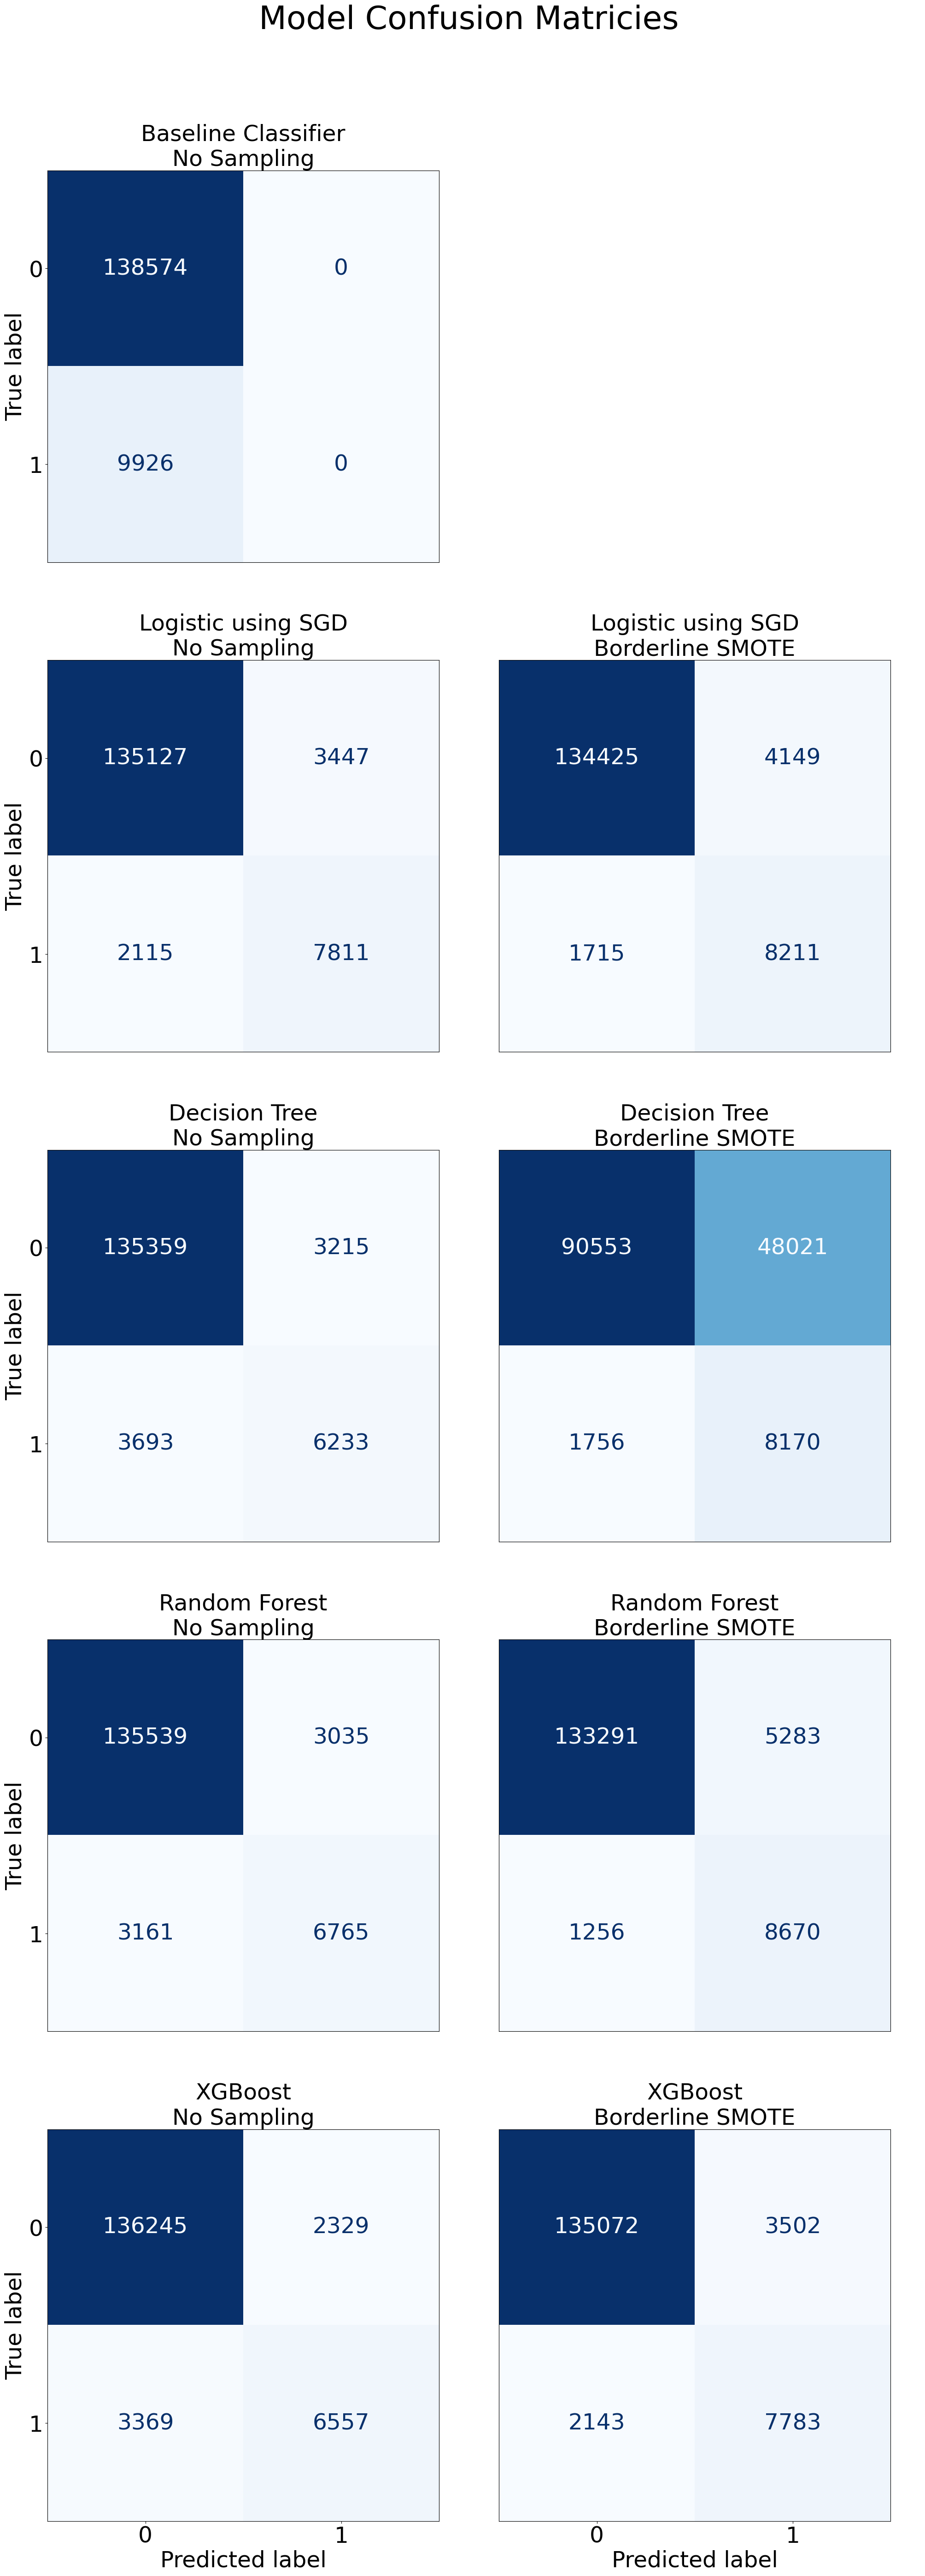

In [30]:
################################################################################
# Create an export a combined confusion matrix plot
################################################################################
# Set graph specific parameters
label_size = 35
title_size = 50
colorbar = False
cmap = 'Blues'

# Set global options and create subplot
plt.rcParams.update({'font.size':label_size})
fig, axes = plt.subplots(5, 2, figsize=(20,60))
fig.suptitle('Model Confusion Matricies', y=.96, size=title_size)
plt.subplots_adjust(left=.01, right=.99, wspace=0,
                    bottom=.05, top=.9, hspace=.25)

# Plot on Axis [0,0]
ConfusionMatrixDisplay(model_results['nosampling_baseline'][2]).plot(ax=axes[0,0], colorbar=colorbar, cmap=cmap)
axes[0,0].set_title('Baseline Classifier\nNo Sampling', size=label_size)
axes[0,0].set_xlabel('')
axes[0,0].tick_params(bottom=False, labelbottom=False)

# Remove plot on Axis [0,1]
axes[0,1].get_xaxis().set_visible(False)
axes[0,1].get_yaxis().set_visible(False)
axes[0,1].spines['top'].set_visible(False)
axes[0,1].spines['bottom'].set_visible(False)
axes[0,1].spines['left'].set_visible(False)
axes[0,1].spines['right'].set_visible(False)


# Plot on Axis [1,0]
ConfusionMatrixDisplay(model_results['nosampling_lr'][2]).plot(ax=axes[1,0], colorbar=False, cmap=cmap)
axes[1,0].set_title('Logistic using SGD\nNo Sampling', size=label_size)
axes[1,0].set_xlabel('')
axes[1,0].tick_params(bottom=False, labelbottom=False)

# Plot on Axis [1,1]
ConfusionMatrixDisplay(model_results['borderlineSMOTE_lr'][2]).plot(ax=axes[1,1], colorbar=False, cmap=cmap)
axes[1,1].set_title('Logistic using SGD\nBorderline SMOTE', size=label_size)
axes[1,1].set_xlabel('')
axes[1,1].set_ylabel('')
axes[1,1].tick_params(bottom=False, labelbottom=False,
                      left=False, labelleft=False)

# Plot on Axis [2,0]
ConfusionMatrixDisplay(model_results['nosampling_dt'][2]).plot(ax=axes[2,0], colorbar=False, cmap=cmap)
axes[2,0].set_title('Decision Tree\nNo Sampling', size=label_size)
axes[2,0].set_xlabel('')
axes[2,0].tick_params(bottom=False, labelbottom=False)

# Plot on Axis [2,1]
ConfusionMatrixDisplay(model_results['borderlineSMOTE_dt'][2]).plot(ax=axes[2,1], colorbar=False, cmap=cmap)
axes[2,1].set_title('Decision Tree\nBorderline SMOTE', size=label_size)
axes[2,1].set_xlabel('')
axes[2,1].set_ylabel('')
axes[2,1].tick_params(left=False, labelleft=False,
                      bottom=False, labelbottom=False)

# Plot on Axis [3,0]
ConfusionMatrixDisplay(model_results['nosampling_rf'][2]).plot(ax=axes[3,0], colorbar=False, cmap=cmap)
axes[3,0].set_title('Random Forest\nNo Sampling', size=label_size)
axes[3,0].set_xlabel('')
axes[3,0].tick_params(bottom=False, labelbottom=False)

# Plot on Axis [3,1]
ConfusionMatrixDisplay(model_results['borderlineSMOTE_rf'][2]).plot(ax=axes[3,1], colorbar=False, cmap=cmap)
axes[3,1].set_title('Random Forest\nBorderline SMOTE', size=label_size)
axes[3,1].set_xlabel('')
axes[3,1].set_ylabel('')
axes[3,1].tick_params(left=False, labelleft=False,
                      bottom=False, labelbottom=False)


# Plot on Axis [4,0]
ConfusionMatrixDisplay(model_results['nosampling_xgb'][2]).plot(ax=axes[4,0], colorbar=False, cmap=cmap)
axes[4,0].set_title('XGBoost\nNo Sampling', size=label_size)

# Plot on Axis [4,1]
ConfusionMatrixDisplay(model_results['borderlineSMOTE_xgb'][2]).plot(ax=axes[4,1], colorbar=False, cmap=cmap)
axes[4,1].set_title('XGBoost\nBorderline SMOTE', size=label_size)
axes[4,1].set_ylabel('')
axes[4,1].tick_params(left=False, labelleft=False)

# Save plot
plt.savefig('assets/models_cm.png')

In [31]:
################################################################################
# Create Performance Metrics Table from Classification Reports
################################################################################

warnings.filterwarnings('ignore', category=DeprecationWarning)

def model_metrics_df(class_rpt, model_nm, train=True):
    """Takes a metric report from Scikit learn and preps a data frame of the data

    Args:
        class_rpt (dict): Dictionary output from the Scikit Learn classification
        report
        model_nm (str): name of the model to be used in the output
        train (bool, optional): flag indicating if the data used was from the training
        set. Defaults to True.

    Returns:
        DataFrame: a dataframe of key performance metrics for a model
    """
    if train == True:
        set_type = ['Train, Class 0', 'Train, Class 1']
    else:
        set_type = ['Test, Class 0', 'Test, Class 1']
    
    return pd.DataFrame({'Model':[model_nm, model_nm],
                         'Set Type, Class':set_type,
                         'Precision':[class_rpt['False']['precision'],
                                      class_rpt['True']['precision']],
                         'Recall':[class_rpt['False']['recall'],
                                      class_rpt['True']['recall']],
                         'F1Score':[class_rpt['False']['f1-score'],
                                      class_rpt['True']['f1-score']],
                         'Support':[class_rpt['False']['support'],
                                      class_rpt['True']['support']],
                         'Accuracy':[class_rpt['accuracy'], np.nan]})

pfm_nosampling_tab = pd.concat([model_metrics_df(model_results['nosampling_baseline'][0], 'Baseline'),
                                model_metrics_df(model_results['nosampling_baseline'][1], 'Baseline', train=False),
                                model_metrics_df(model_results['nosampling_lr'][0], 'Logistic w/ SGD'),
                                model_metrics_df(model_results['nosampling_lr'][1], 'Logistic w/ SGD', train=False),
                                model_metrics_df(model_results['nosampling_dt'][0], 'Decision Tree'),
                                model_metrics_df(model_results['nosampling_dt'][1], 'Decision Tree', train=False),
                                model_metrics_df(model_results['nosampling_rf'][0], 'Random Forest'),
                                model_metrics_df(model_results['nosampling_rf'][1], 'Random Forest', train=False),
                                model_metrics_df(model_results['nosampling_xgb'][0], 'XGBoost'),
                                model_metrics_df(model_results['nosampling_xgb'][1], 'XGBoost', train=False)])

pfm_borderlineSMOTE_tab = pd.concat([model_metrics_df(model_results['borderlineSMOTE_lr'][0], 'Logistic w/ SGD'),
                                     model_metrics_df(model_results['borderlineSMOTE_lr'][1], 'Logistic w/ SGD', train=False),
                                     model_metrics_df(model_results['borderlineSMOTE_dt'][0], 'Decision Tree'),
                                     model_metrics_df(model_results['borderlineSMOTE_dt'][1], 'Decision Tree', train=False),
                                     model_metrics_df(model_results['borderlineSMOTE_rf'][0], 'Random Forest'),
                                     model_metrics_df(model_results['borderlineSMOTE_rf'][1], 'Random Forest', train=False),
                                     model_metrics_df(model_results['borderlineSMOTE_xgb'][0], 'XGBoost'),
                                     model_metrics_df(model_results['borderlineSMOTE_xgb'][1], 'XGBoost', train=False)])

pfm_tab = (pfm_nosampling_tab.merge(pfm_borderlineSMOTE_tab, 
                                    on=['Model', 'Set Type, Class'],
                                    suffixes=['_nosampling', '_borderlineSMOTE'],
                                    how='left')
                             .drop('Support_nosampling', axis=1))


nosampling_cols = ['Precision_nosampling', 'Recall_nosampling', 'F1Score_nosampling', 'Accuracy_nosampling']
sampled_cols = ['Precision_borderlineSMOTE', 'Recall_borderlineSMOTE', 'F1Score_borderlineSMOTE',
                        'Accuracy_borderlineSMOTE']

performance_metric_table = (GT(pfm_tab)
 .fmt_number(columns=['Precision_nosampling', 'Recall_nosampling',
                      'F1Score_nosampling', 'Accuracy_nosampling',
                      'Precision_borderlineSMOTE', 'Recall_borderlineSMOTE',
                      'F1Score_borderlineSMOTE', 'Accuracy_borderlineSMOTE'],
             decimals=3)
 .fmt_number(columns=['Support_borderlineSMOTE'], decimals=0)
 .cols_label(
     Precision_nosampling='Precision',
     Recall_nosampling='Recall',
     F1Score_nosampling='F1-Score',
     Accuracy_nosampling='Accuracy',
     Precision_borderlineSMOTE='Precision',
     Recall_borderlineSMOTE='Recall',
     F1Score_borderlineSMOTE='F1-Score',
     Accuracy_borderlineSMOTE='Accuracy',
     Support_borderlineSMOTE='Support'
 )
 .tab_stub(rowname_col='Set Type, Class', groupname_col='Model')
 .tab_spanner('No Sampling', columns=nosampling_cols)
 .tab_spanner('Sampled*', columns=sampled_cols)
 .tab_header(title='Performance Metrics', subtitle=' by Model and Sampling Method')
 .opt_stylize(style=1, color='blue')
 .tab_source_note(md('_*Sampled with Borderline SMOTE and then with Edited Nearest Neighbors_')))

# Show and save the table
performance_metric_table.show()
#performance_metric_table.save('assets/performance_metrics_table.png')

# Turn deprecation warnings back on
warnings.filterwarnings('always', category=DeprecationWarning)


Performance Metrics 
 
 
 by Model and Sampling Method 
 
 
 
 
 No Sampling 
 
 
 Sampled* 
 
 Support 
 
 
 Precision 
 Recall 
 F1-Score 
 Accuracy 
 Precision 
 Recall 
 F1-Score 
 Accuracy 
 
 
 
 
 Baseline 
 
 
 Train, Class 0 
 0.933 
 1.000 
 0.966 
 0.933 
 
 
 
 
 
 
 
 Train, Class 1 
 0.000 
 0.000 
 0.000 
 
 
 
 
 
 
 
 
 Test, Class 0 
 0.933 
 1.000 
 0.965 
 0.933 
 
 
 
 
 
 
 
 Test, Class 1 
 0.000 
 0.000 
 0.000 
 
 
 
 
 
 
 
 
 Logistic w/ SGD 
 
 
 Train, Class 0 
 0.983 
 0.977 
 0.980 
 0.963 
 0.987 
 0.970 
 0.978 
 0.960 
 1,400 
 
 
 Train, Class 1 
 0.704 
 0.760 
 0.731 
 
 0.661 
 0.820 
 0.732 
 
 100 
 
 
 Test, Class 0 
 0.985 
 0.975 
 0.980 
 0.963 
 0.987 
 0.970 
 0.979 
 0.961 
 138,574 
 
 
 Test, Class 1 
 0.694 
 0.787 
 0.737 
 
 0.664 
 0.827 
 0.737 
 
 9,926 
 
 
 Decision Tree 
 
 
 Train, Class 0 
 0.978 
 0.979 
 0.979 
 0.960 
 0.981 
 0.654 
 0.784 
 0.665 
 1,400 
 
 
 Train, Class 1 
 0.704 
 0.690 
 0.697 
 
 0.145 
 0.820 
 0.246 
 
 100 
 
 
 Test, Class 0 
 0.973 
 0.977 
 0.975 
 0.953 
 0.981 
 0.653 
 0.784 
 0.665 
 138,574 
 
 
 Test, Class 1 
 0.660 
 0.628 
 0.643 
 
 0.145 
 0.823 
 0.247 
 
 9,926 
 
 
 Random Forest 
 
 
 Train, Class 0 
 0.982 
 0.982 
 0.982 
 0.967 
 0.989 
 0.963 
 0.976 
 0.955 
 1,400 
 
 
 Train, Class 1 
 0.750 
 0.750 
 0.750 
 
 0.620 
 0.850 
 0.717 
 
 100 
 
 
 Test, Class 0 
 0.977 
 0.978 
 0.978 
 0.958 
 0.991 
 0.962 
 0.976 
 0.956 
 138,574 
 
 
 Test, Class 1 
 0.690 
 0.682 
 0.686 
 
 0.621 
 0.873 
 0.726 
 
 9,926 
 
 
 XGBoost 
 
 
 Train, Class 0 
 0.984 
 0.998 
 0.991 
 0.983 
 0.989 
 0.992 
 0.991 
 0.983 
 1,400 
 
 
 Train, Class 1 
 0.963 
 0.780 
 0.862 
 
 0.885 
 0.850 
 0.867 
 
 100 
 
 
 Test, Class 0 
 0.976 
 0.983 
 0.980 
 0.962 
 0.984 
 0.975 
 0.980 
 0.962 
 138,574 
 
 
 Test, Class 1 
 0.738 
 0.661 
 0.697 
 
 0.690 
 0.784 
 0.734 
 
 9,926 
 
 
 
 
 
 *Sampled with Borderline SMOTE and then with Edited Nearest Neighbors

In [32]:
# Choose a threshold for the Random Forest with Sampling
thresholds = np.linspace(0, 1, 200)
metric_list = []

for threshold in thresholds:
    preds = np.where(rf_grid.predict_proba(X_test)[:,1] > threshold, 1, 0)
    metric_list.append([precision_score(y_test, preds),
                        recall_score(y_test, preds),
                        f1_score(y_test, preds),
                        accuracy_score(y_test, preds)])
    
metric_df = pd.DataFrame(metric_list, columns=['Precision', 'Recall', 'F1-Score', 'Accuracy'])
metric_df['Threshold'] = thresholds               
metric_df = metric_df.melt(id_vars=['Threshold'], value_name='Value', var_name='Metric')



/opt/conda/envs/loan_default/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/envs/loan_default/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/envs/loan_default/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/envs/loa

Threshold     Metric     Value
0   0.000000  Precision  0.066842
1   0.005025  Precision  0.066842
2   0.010050  Precision  0.066842
3   0.015075  Precision  0.066842
4   0.020101  Precision  0.066842

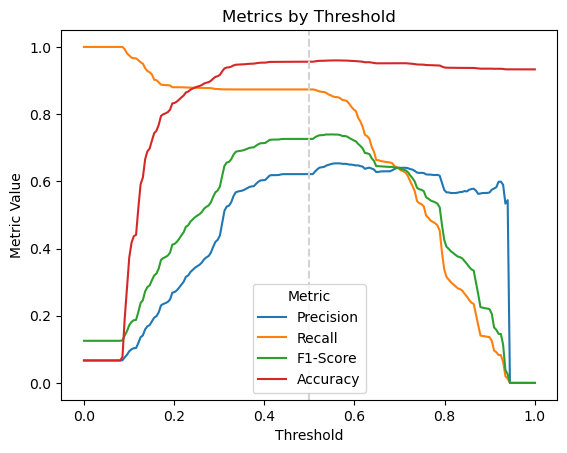

In [33]:
display(metric_df.head())
sns.reset_orig()
cht = sns.lineplot(metric_df, x='Threshold', y='Value', hue='Metric')
cht.set_title('Metrics by Threshold')
cht.set_xlabel('Threshold')
cht.set_ylabel('Metric Value')
cht.axvline(0.5, ls='--', color='lightgrey')
plt.show()

In [34]:

# Print the program end time
end_time = datetime.datetime.now()
print(f'End time: {end_time:%Y-%m-%d %H:%M}')


End time: 2025-01-22 01:34


## References

***Quiroz, H. F. (2024). credit default only numeric data. Kaggle.com. https://www.kaggle.com/datasets/hugoferquiroz/credit-default-only-numbers**